In [1]:
dataset_name = "exchange-2_cpc_results"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Preprocess dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, 
                                                                   '1H', data))

# if you want to use a method that cannot take missing time steps
# into account, you need to fill in the missing time steps yourself
# this function also removes duplicates
print("Fill Missing Time Steps with Interpolation")
data = adclasses.fill_missing_time_steps(start_date, end_date, '1H', data, method="linear")

# write to csv for htm
# data.to_csv("/home/cfreeman/Desktop/prefill/" + dataset_name + ".csv", index=False)

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, 
                                          timestep="1H", 
                                          dateformat="%Y-%m-%d %H:%M:%S", 
                                          name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2011-07-14 13:00:01"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2011-07-01 00:00:01
End date:  2011-09-07 15:00:01
Missing time stamps: 
 DatetimeIndex(['2011-07-21 05:00:01', '2011-08-08 18:00:01',
               '2011-08-10 16:00:01', '2011-08-15 22:00:01',
               '2011-08-15 23:00:01', '2011-09-01 19:00:01',
               '2011-09-01 20:00:01', '2011-09-01 21:00:01',
               '2011-09-01 22:00:01', '2011-09-01 23:00:01',
               '2011-09-02 00:00:01', '2011-09-02 01:00:01',
               '2011-09-02 02:00:01', '2011-09-02 03:00:01',
               '2011-09-02 04:00:01', '2011-09-02 05:00:01',
               '2011-09-02 06:00:01', '2011-09-02 07:00:01',
               '2011-09-02 08:00:01', '2011-09-02 09:00:01',
               '2011-09-02 10:00:01', '2011-09-02 11:00:01',
               '2011-09-02 12:00:01', '2011-09-02 13:00:01',
               '2011-09-02 14:00:01'],
              dtype='datetime64[ns]', freq=None)
Fill Missing Time Steps with Interpolation
Duplicate records found: 
                        

# GLM

In [4]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='gaussian', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

100%|██████████| 1648/1648 [00:00<00:00, 17781.53it/s]

Initial Mean 0.08890310714170364
Initial StdDev 0.038660775450933875



100%|██████████| 1648/1648 [00:00<00:00, 18894.76it/s]

eta:  0.5
lambda:  0.99
MSE:  0.00036918392291091537
Initial Mean 0.08890310714170364
Initial StdDev 0.038660775450933875



100%|██████████| 1648/1648 [00:00<00:00, 14653.24it/s]

eta:  0.5
lambda:  0.999
MSE:  0.0005376633708638394
Initial Mean 0.08890310714170364
Initial StdDev 0.038660775450933875



100%|██████████| 1648/1648 [00:00<00:00, 16760.66it/s]

eta:  0.5
lambda:  0.9999
MSE:  0.0005705316788647911
Initial Mean 0.08890310714170364
Initial StdDev 0.038660775450933875



100%|██████████| 1648/1648 [00:00<00:00, 18843.76it/s]

eta:  1
lambda:  0.99
MSE:  0.00030299540452918047
Initial Mean 0.08890310714170364
Initial StdDev 0.038660775450933875



100%|██████████| 1648/1648 [00:00<00:00, 15560.44it/s]

eta:  1
lambda:  0.999
MSE:  0.0004557496236018577
Initial Mean 0.08890310714170364
Initial StdDev 0.038660775450933875


eta:  1
lambda:  0.9999
MSE:  0.0004988180981491845

best params:  eta 1 lambda 0.99


100%|██████████| 1648/1648 [00:00<00:00, 16432.61it/s]

Initial Mean 0.08890310714170364
Initial StdDev 0.038660775450933875


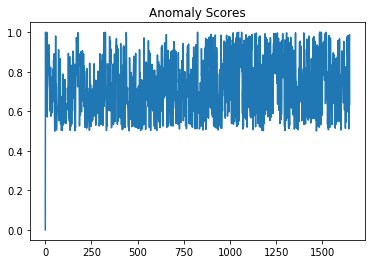

Time:  0.40915799140930176


['anomaly_scores/GLM/exchange-2_cpc_results']

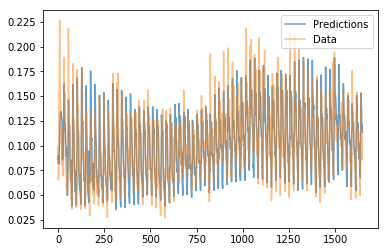

In [5]:
save_path = "anomaly_scores/GLM/" + dataset_name
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='gaussian', 
                     eta=int(best_params[4:6]),
                     lambda_=float(best_params[14:]),
                     plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)


# Anomalous

In [6]:
# only need one window size

# save_path = "anomaly_scores/anomalous/" + dataset_name
# output_dict = ad.anomalous(ts_length=100,
#                            upper=(.2/100) * ad.get_length(),
#                            plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# SARIMA: using autoarima


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -1444.096
 Regression with ARIMA(0,1,0) errors : -1442.256
 Regression with ARIMA(1,1,0) errors : -1442.391
 Regression with ARIMA(0,1,1) errors : -1465.409
 ARIMA(0,1,0)                    : -1444.874
 Regression with ARIMA(1,1,1) errors : -1440.566
 Regression with ARIMA(0,1,2) errors : -1468.183
 Regression with ARIMA(1,1,2) errors : -1462.129
 Regression with ARIMA(0,1,3) errors : -1465.132
 Regression with ARIMA(1,1,3) errors : -1438.305
 ARIMA(0,1,2)                    : -1471.818
 ARIMA(0,1,1)                    : -1470.014
 ARIMA(1,1,2)                    : -1471.73
 ARIMA(0,1,3)                    : -1469.221
 ARIMA(1,1,1)                    : -1463.833
 ARIMA(1,1,3)                    : -1469.112

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,2)                    : -1480.977

 Best model: Regression with ARIMA(0,1,2) errors 



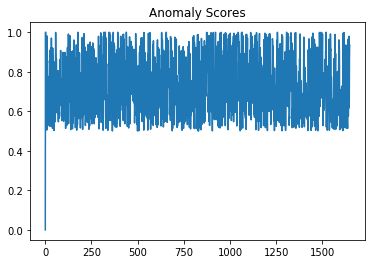

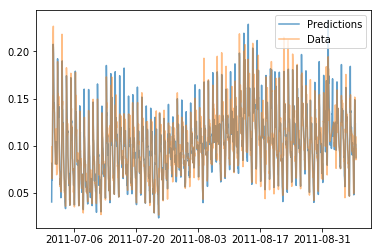

Time:  10.156561613082886


['anomaly_scores/SARIMA_auto/exchange-2_cpc_results']

In [7]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, s=24, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Facebook Prophet

In [8]:
# optimization step

step_sizes = [100, 200]
seasonality_prior_scales = [1, 5, 10, 15, 20]
seasonality_modes = ["additive", "multiplicative"]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for seasonality_prior_scale in seasonality_prior_scales:
        for seasonality_mode in seasonality_modes:
            for changepoint_prior_scale in changepoint_prior_scales:
                
                mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                          daily_seasonality=True, 
                                          seasonality_prior_scale=seasonality_prior_scale,
                                          seasonality_mode=seasonality_mode,
                                          changepoint_prior_scale=changepoint_prior_scale,
                                          step_size=step_size,
                                          optimize=True)
                print("Step Size: ", step_size)
                print("Seasonality Prior Scale: ", seasonality_prior_scale)
                print("Seasonality Mode: ", seasonality_mode)
                print("Changepoint Prior Scale: ", changepoint_prior_scale)
                print("MSE: ",mse)
                
                key_str = "Step Size " + str(step_size) + " Seasonality Prior Scale " + str(seasonality_prior_scale) +" Seasonality Mode " + str(seasonality_mode) +" Changepoint Prior Scale" + str(changepoint_prior_scale)
                
                opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0003318175988150563


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00020739818609829302


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.00015763471036195828


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0001516679164085237


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00015025222555794057


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00038848125390540704


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.00023861886102089175


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0001847807375626909


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.00017402158219965853


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0001708395404437174


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.00033317323584574195


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00021367500361081608


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.00015777031441962887


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00015157738398140918


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00014977485886605426


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00038224027423989707


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.00024388067578274972


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.00018433112969210607


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.00017439897381999088


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0001704569448434833


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0003330188740267543


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0001878690426490299


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.00015714231924145291


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00015149764976495284


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00015014527263986895


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0003864264570531525


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0002447812879802205


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0001809234886368098


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0001744649612183636


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0001703721802397102


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.00033148510151749283


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00020421249514432181


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0001569024410360994


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00015157635490742327


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00015000350955019745


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00038799880181807577


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0002505133120553324


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.00018401157473275128


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.00017549758890790694


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.00017017902655297633


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.00032561547979642695


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00021131656558539308


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.00015755622689909643


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00015163821874045576


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00015030267558411868


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0003821911962479874


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0002371159173057123


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.00018553515422868453


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0001738051456463579


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.00017055307819128983


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0003318175988150563


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00020739818609829302


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.00015763471036195828


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0001516679164085237


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00015025222555794057


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00038848125390540704


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.00023861886102089175


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0001847807375626909


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.00017402158219965853


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0001708395404437174


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.00033317323584574195


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00021367500361081608


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.00015777031441962887


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00015157738398140918


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00014977485886605426


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00038224027423989707


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.00024388067578274972


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.00018433112969210607


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.00017439897381999088


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0001704569448434833


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0003330188740267543


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0001878690426490299


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.00015714231924145291


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00015149764976495284


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00015014527263986895


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0003864264570531525


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0002447812879802205


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0001809234886368098


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0001744649612183636


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0001703721802397102


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.00033148510151749283


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00020421249514432181


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0001569024410360994


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00015157635490742327


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00015000350955019745


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00038799880181807577


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0002505133120553324


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.00018401157473275128


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.00017549758890790694


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.00017017902655297633


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.00032561547979642695


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00021131656558539308


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.00015755622689909643


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00015163821874045576


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00015030267558411868


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0003821911962479874


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0002371159173057123


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.00018553515422868453


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0001738051456463579
Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.00017055307819128983

best params:  Step Size 100 Seasonality Prior Scale 5 Seasonality Mode additive Changepoint Prior Scale0.2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


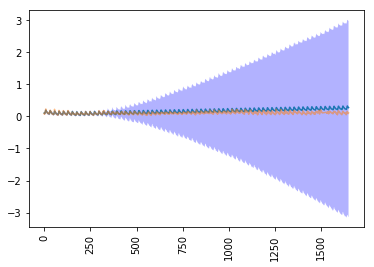

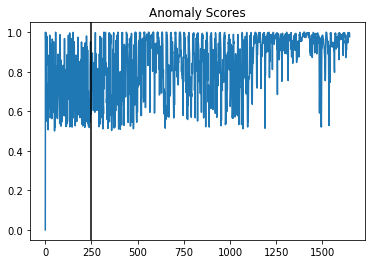

Time:  20.151180267333984


['anomaly_scores/Prophet/exchange-2_cpc_results']

In [9]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  daily_seasonality=True, 
                                  seasonality_prior_scale=5,
                                  seasonality_mode="additive",
                                  changepoint_prior_scale=.2,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Twitter AD

In [10]:
# only need one window size

# save_path = "anomaly_scores/Twitter/" + dataset_name
# output_dict = ad.twitterad(period=24,max_anoms=((.2/100) * ad.get_length())/ad.get_length(), direction='both', alpha=.001, plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# HTM

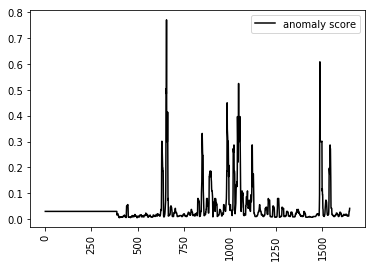

Time:  17.19


['anomaly_scores/HTM/exchange-2_cpc_results']

In [11]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"
htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", "17.19")
output_dict = {"Anomaly Scores": anomaly_scores, "Time": "17.19"}
joblib.dump(output_dict, save_path)

# STL Resid

In [12]:
# optimization step
swindows = ["periodic", 5,7,9,11]
sdegrees = [0,1,2]
twindows = [5,7,9,11]
tdegrees = [0,1,2]
inners = [1,2,3]
outers = [0,1]
opt_dict = {}

for swindow in swindows:
    for sdegree in sdegrees:
        for twindow in twindows:
            for tdegree in tdegrees:
                for inner in inners:
                    for outer in outers:
                        
                        print("swindow: ", swindow)
                        print("sdegree: ", sdegree)
                        print("twindow: ", twindow)
                        print("tdegree: ", tdegree)
                        print("inner: ", inner)
                        print("outer: ", outer)
                        
                        
                        try:
  
                            stl_resid_sum = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=swindow, 
                                                         sdegree=sdegree, twindow=twindow, tdegree=tdegree, inner=inner, 
                                                         outer=outer, fill_option="linear", optimize=True)


                            print("STL Resid Sum: ",stl_resid_sum)

                            key_str = "swindow " + str(swindow) + " sdegree " + str(sdegree) +" twindow " + str(twindow) +" tdegree " + str(tdegree) +" inner " + str(inner) +" outer " + str(outer)

                            opt_dict[key_str] = stl_resid_sum

                        except:
                            print("Fail")
                            continue

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.006297415627620497
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00630357014387894
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.006297451430056821
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.006297415627620497
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.006297696563685254
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.006297278999343885
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  1
inne

R stlplus completed: 247 no missing True
STL Resid Sum:  0.007600778100572758
swindow:  periodic
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.007602673056086452
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.014328016377427831
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.014398767834103236
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.014315339264111531
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.014328016377427831
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Su

R stlplus completed: 247 no missing True
STL Resid Sum:  0.004831485793386979
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.004825479108919671
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.004828929372697057
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.012227744103438172
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.012273204401105475
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.012218653284029745
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0

R stlplus completed: 247 no missing True
STL Resid Sum:  0.00011033134107083366
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00012914508736705917
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  9.425836530576024e-05
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00011936813093082116
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00968044397466382
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.009696272202580096
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid S

R stlplus completed: 247 no missing True
STL Resid Sum:  0.009611211478342936
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.009578643746485335
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00958750174095809
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.009575405017740624
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.009581703611979115
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00431307777644393
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00419583916

R stlplus completed: 247 no missing True
STL Resid Sum:  0.005296898112647823
swindow:  5
sdegree:  0
twindow:  9
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005270567534768508
swindow:  5
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005303610228237713
swindow:  5
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005290217360366616
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.008585092190801748
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00857361085968582
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.008616540660184859
swindow:  5
sdegree:

R stlplus completed: 247 no missing True
STL Resid Sum:  0.002680517980927413
swindow:  5
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.002649920308706445
swindow:  5
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0026731029328651026
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.006102606878220585
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.006165742454582204
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.006079862308092143
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.006102606878220585
swindow:  5
sdegree: 

R stlplus completed: 247 no missing True
STL Resid Sum:  8.412638314195096e-08
swindow:  5
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.6287188104850884e-07
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0008063475757688277
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0007957124949895294
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0008249774360379121
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0008063475757688277
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0008197996483736731
swindow:  5
sd

R stlplus completed: 247 no missing True
STL Resid Sum:  0.0007586422797616451
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005134383921885278
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00506150893903204
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0051784244188947314
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005134383921885278
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005193169965646411
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005163716873568473
swindow:  7
sdegree: 

R stlplus completed: 247 no missing True
STL Resid Sum:  0.01068331389932707
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.010652769616897173
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.010734544945785884
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.01068331389932707
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.010755207321443123
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.010715828519226523
swindow:  7
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.010055750999055797
swindow:  7
sdegre

R stlplus completed: 247 no missing True
STL Resid Sum:  0.008507062203991788
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00845031187050664
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.008466702733316855
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.008443559233070691
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.008457016797889199
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.008229931393505396
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00829927616895129
swindow:  7
sdegree:  1


R stlplus completed: 247 no missing True
STL Resid Sum:  0.004590117611219314
swindow:  7
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0046111596028620295
swindow:  7
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00457173005249569
swindow:  7
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.004602038265292423
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.004575855100689897
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.004637919395415635
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.004522838325540321
swindow:  7
sdegree:  

R stlplus completed: 247 no missing True
STL Resid Sum:  0.005390844686266431
swindow:  9
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005442072401268672
swindow:  9
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005418769077346118
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005384310805558854
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005334550231898284
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0054205071623447945
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005384310805558854
swindow:  9
sdegree: 

R stlplus completed: 247 no missing True
STL Resid Sum:  0.011672916295824823
swindow:  9
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.011633844676247581
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.01094551690691109
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.010819731817333152
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.010997851965767287
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.01094551690691109
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.011005027452989828
swindow:  9
sdegre

R stlplus completed: 247 no missing True
STL Resid Sum:  0.009532161465650441
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.009287861926075745
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.009358389345825491
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0092746342713489
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.009287861926075745
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0092708789418423
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.009278472779698217
swindow:  9
sdegree:  1
tw

R stlplus completed: 247 no missing True
STL Resid Sum:  0.005749750209208141
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005843130571667951
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00570028890917957
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005749750209208141
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005682087308449401
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0057182748280775455
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.002942847110412925
swindow:  9
sdegree:  

R stlplus completed: 247 no missing True
STL Resid Sum:  0.005648369201000256
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005715135136367485
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005686330428968737
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005718601862467681
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.005707820502255308
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00012497838255763402
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00013108682400220044
swindow:  11

R stlplus completed: 247 no missing True
STL Resid Sum:  0.011787810121145175
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.011745693135082821
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.011790974709515933
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.011779302329400278
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.008790242637673728
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.008758200887477354
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.008814408061171565
swindow:  

R stlplus completed: 247 no missing True
STL Resid Sum:  0.009884382006993944
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.009865397229240555
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.009874095710084681
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0065443914201585435
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.006577678592880105
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.006532728268543155
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0065443914201585435
swindow:  11
s

R stlplus completed: 247 no missing True
STL Resid Sum:  0.00642564498774974
swindow:  11
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.00643755114073576
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0032278992105391224
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0032733894569586036
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0032097827653832507
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0032278992105391224
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.003201746744512585
swindow:  11
s

In [13]:
save_path = "anomaly_scores/stl/" + dataset_name
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=5, 
             sdegree=2, twindow=5, tdegree=2, inner=3, 
             outer=0, fill_option="linear", optimize=False)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

1648
R stlplus completed: 1648 no missing True
Time:  1.4898247718811035


['anomaly_scores/stl/exchange-2_cpc_results']

# windowed gaussian

In [14]:
# optimization step
step_sizes = [100, 200, 300, 400, 500]

opt_dict = {}

for step_size in step_sizes:
    print("Step size: ", step_size)
    output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                       step_size = step_size, 
                                       optimize=True,
                                       plot_anomaly_score=False)
    print("MSE: ", output_dict["MSE"])
    opt_dict[step_size] = output_dict["MSE"]

best_step_size = min(opt_dict, key=opt_dict.get)
print("\nbest step size: ", best_step_size)

Step size:  100
MSE:  0.0015513548263058979
Step size:  200
MSE:  0.0015513548263058979
Step size:  300
MSE:  0.0015513548263058979
Step size:  400
MSE:  0.0015513548263058979
Step size:  500
MSE:  0.0015513548263058979

best step size:  100


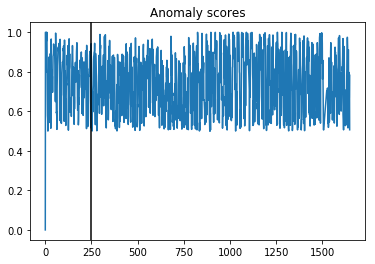

Time:  0.19927620887756348


['anomaly_scores/windowed_gaussian/exchange-2_cpc_results']

In [15]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name

output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                   step_size = best_step_size, 
                                   plot_anomaly_score=True)

print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

In [16]:
# only need one window size

# save_path = "anomaly_scores/hotsax/" + dataset_name
# output_dict = ad.hotsax(win_size=50, num_discords=int((.2/100) * ad.get_length()),
#                a_size=3, paa_size=3, z_threshold=0.01,
#                plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)